In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *
from tomopt.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

<ipython-input-4-edc514db5f58>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-10, 100*100)


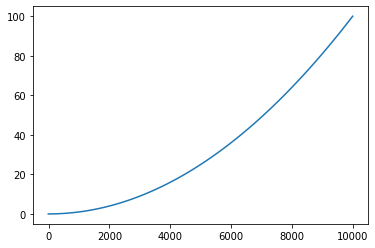

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x/1000)**2

x = torch.linspace(-10, 100*100)
plt.plot(x, area_cost(x))

# Detector panels

In [5]:
c = torch.tensor([0.5,0.5], requires_grad=True)
s = torch.tensor([0.5,1], requires_grad=True)

In [6]:
gauss = torch.distributions.Normal(c, s)

In [7]:
torch.prod(torch.exp(gauss.log_prob(Tensor([[0.5,0.5], [1,1]])))/torch.exp(gauss.log_prob(Tensor([0.5,0.5]))),dim=-1)

tensor([1.0000, 0.5353], grad_fn=<ProdBackward1>)

In [8]:
class DetectorPanel(nn.Module):
    def __init__(
        self,
        res: float,
        eff: float,
        init_xyz:Tuple[float,float,float],
        init_xy_span: Tuple[float,float],
        area_cost_func: Callable[[Tensor], Tensor],
        device: torch.device = DEVICE
    ):
        if res <= 0:
            raise ValueError(f'Resolution must be positive')
        if eff <= 0:
            raise ValueError(f'Efficiency must be positive')
            
        super().__init__()
        self.area_cost_func, self.device = area_cost_func, device
        self.register_buffer('resolution', torch.tensor(float(res), requires_grad=True, device=self.device))
        self.register_buffer('efficiency', torch.tensor(float(eff), requires_grad=True, device=self.device))
        self.xyz = nn.Parameter(torch.tensor(init_xyz, device=self.device))
        self.xy_span = nn.Parameter(torch.tensor(init_xy_span, device=self.device))
        self.realistic_validation = False
        
    def __repr__(self) -> str:
        return f'''{self.__class__} located at {self.xyz.data}, and xy span {self.xy_span.data}'''
    
    def get_xy_mask(self, xy: Tensor) -> Tensor:
        xy_low = self.xy-(self.xy_span/2)
        xy_high = self.xy+(self.xy_span/2)
        return (xy[:,0] >= xy_low[0]) * (xy[:,0] < xy_high[0]) * (xy[:,1] >= xy_low[1]) * (xy[:,1] < xy_high[1])
    
    def get_resolution(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training or not self.realistic_validation:
            gauss = torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
            res = self.resolution*torch.exp(gauss.log_prob(xy))/torch.exp(gauss.log_prob(self.xy))  # Maybe detach the normalisation?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            res = torch.zeros((len(xy),2), device=self.device)  # Zero detection outside detector
            res[mask] = self.resolution
        return res
    
    def get_efficiency(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training or not self.realistic_validation:
            gauss = torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
            scale = torch.exp(gauss.log_prob(xy))/torch.exp(gauss.log_prob(self.xy))  # Maybe detach the normalisation?
            eff = self.efficiency*torch.prod(scale, dim=-1)  # Maybe weight product by xy distance?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            eff = torch.zeros(len(xy), device=self.device)  # Zero detection outside detector
            eff[mask] = self.efficiency
        return eff
        
    def get_hits(self, mu: MuonBatch) -> Dict[str, Tensor]:
        mask = mu.get_xy_mask(self.xy-(self.xy_span/2), self.xy+(self.xy_span/2))  # Muons in panel
        
        xy0 = self.xy-(self.xy_span/2)  # Low-left of voxel
        rel_xy = mu.xy - xy0
        res = self.get_resolution(mu.xy, mask)        
        rel_xy = rel_xy + (torch.randn((len(mu), 2), device=self.device) / res)
        
        if not self.training and self.realistic_validation:  # Prevent reco hit from exiting panel
            span = self.xy_span.detach().cpu().numpy()
            rel_xy[mask] = torch.stack([torch.clamp(rel_xy[mask][:,0], 0, span[0]),
                                        torch.clamp(rel_xy[mask][:,1], 0, span[1])], dim=-1)  
        reco_xy = xy0 + rel_xy

        hits = {
            "reco_xy": reco_xy,
            "gen_xy": mu.xy.detach().clone(),
            "z": self.z.expand_as(mu.x)[:, None],
        }
        return hits

    def get_cost(self) -> Tensor:
        return self.area_cost_func(self.xy_span.prod())
    
    def clamp_params(self, xyz_low:Tuple[float,float,float], xyz_high:Tuple[float,float,float]) -> None:
        with torch.no_grad():
            eps = np.random.uniform(0, 1e-5)  # prevent hits at same z due to clamping
            torch.clamp_(self.x, min=xyz_low[0], max=xyz_high[0])
            torch.clamp_(self.y, min=xyz_low[1], max=xyz_high[1])
            torch.clamp_(self.z, min=xyz_low[2]+eps, max=xyz_high[2]-eps)
            torch.clamp_(self.xy_span[0], min=1e-7, max=xyz_high[0])
            torch.clamp_(self.xy_span[1], min=1e-7, max=xyz_high[1])
            
    @property
    def xy(self) -> Tensor:
        return self.xyz[:2]
    
    @property
    def x(self) -> Tensor:
        return self.xyz[0]
    
    @property
    def y(self) -> Tensor:
        return self.xyz[1]
    
    @property
    def z(self) -> Tensor:
        return self.xyz[2]

In [9]:
from tomopt.volume.layer import Layer

class DetectorLayer(Layer):
    def __init__(
        self,
        pos: str,
        lw: Tensor,
        z: float,
        size: float,
        panels: nn.ModuleList,
        device: torch.device = DEVICE,
    ):
        super().__init__(lw=lw, z=z, size=size, device=device)
        if isinstance(panels, list):
            panels = nn.ModuleList(panels)
        self.pos, self.panels = pos, panels
    
    def get_panel_zorder(self) -> List[int]:
        return np.argsort([p.z.detach().cpu().item() for p in self.panels])[::-1]
        
    def check_panels(self) -> None:
        lw = self.lw.detach().cpu().numpy()
        z = self.z.detach().cpu()[0]
        zs = []
        for p in self.panels:
            p.clamp_params(xyz_low=(0,0,z-self.size), xyz_high=(lw[0],lw[1],z))
            zs.append(p.z)        
                
    def forward(self, mu: MuonBatch) -> None:
        self.check_panels()
        for i in self.get_panel_zorder():
            self.scatter_and_propagate(mu, mu.z-self.panels[i].z)  # Move to panel
            mu.append_hits(self.panels[i].get_hits(mu), self.pos)
        self.scatter_and_propagate(mu, mu.z-(self.z-self.size))  # Move to bottom of layer

    def get_cost(self) -> Tensor:
        for i, p in enumerate(self.panels):
            cost = p.get_cost() if i == 0 else cost + p.get_cost()
        return cost

In [10]:
panels = nn.ModuleList([DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,0.95], init_xy_span=[0.5,0.5], area_cost_func=area_cost),
                        DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,1], init_xy_span=[0.5,0.5], area_cost_func=area_cost)])

In [11]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [12]:
muons.xy.grad

In [13]:
panels[0].get_hits(muons)

{'reco_xy': tensor([[0.1531, 0.3937],
         [0.8078, 0.5248],
         [0.9548, 0.6363],
         [0.7289, 0.7648],
         [0.2188, 0.7506],
         [0.1092, 0.5253],
         [0.8991, 0.3888],
         [0.8964, 0.3923],
         [0.6204, 0.0726],
         [0.3771, 0.3737],
         [0.8117, 0.9693],
         [0.0265, 0.8151],
         [0.3862, 0.3953],
         [0.7767, 0.9188],
         [0.6475, 0.7750],
         [0.3288, 0.6797],
         [0.7257, 0.1564],
         [0.2139, 0.1583],
         [0.5386, 0.9098],
         [0.4027, 0.9061],
         [0.7457, 0.4195],
         [0.8331, 0.6557],
         [0.3406, 0.3434],
         [0.3757, 0.9234],
         [0.2392, 0.6458],
         [0.2179, 0.1242],
         [0.4479, 0.6003],
         [0.8798, 0.8947],
         [0.5376, 0.9983],
         [0.9721, 0.6276],
         [0.9231, 0.6903],
         [0.7040, 0.2643],
         [0.2199, 0.9174],
         [0.2313, 0.0199],
         [0.3233, 0.2515],
         [0.0881, 0.6784],
         [0.0846,

In [14]:
muons.xy.grad

In [15]:
dl = DetectorLayer(pos='above', lw=Tensor([1,1]), z=1, size=0.1, panels=panels)

In [16]:
dl.get_cost()

tensor(1.2500e-07, grad_fn=<AddBackward0>)

In [17]:
dl.get_panel_zorder()

array([1, 0])

In [18]:
dl.panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span tensor([0.5000, 0.5000])
)

In [19]:
dl(muons)

In [20]:
muons.xy.grad

In [21]:
muons.z

tensor([0.9000])

In [22]:
muons.hits

defaultdict(<function tomopt.muon.muon_batch.MuonBatch.__init__.<locals>.<lambda>()>,
            {'above': defaultdict(list,
                         {'reco_xy': [tensor([[0.1528, 0.3938],
                                   [0.8080, 0.5246],
                                   [0.9550, 0.6361],
                                   [0.7287, 0.7646],
                                   [0.2189, 0.7506],
                                   [0.1092, 0.5254],
                                   [0.8992, 0.3891],
                                   [0.8966, 0.3923],
                                   [0.6203, 0.0725],
                                   [0.3774, 0.3737],
                                   [0.8118, 0.9693],
                                   [0.0264, 0.8151],
                                   [0.3862, 0.3953],
                                   [0.7767, 0.9186],
                                   [0.6475, 0.7747],
                                   [0.3288, 0.6798],
               

In [23]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(DetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))
    layers.append(DetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [24]:
class Volume(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        if isinstance(layers, list):
            layers = nn.ModuleList(layers)
        self.layers = layers

    def __getitem__(self, idx:int) -> Layer:
        return self.layers[idx]

    def get_detectors(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, DetectorLayer)]

    def get_passives(self) -> List[PassiveLayer]:
        return [l for l in self.layers if isinstance(l, PassiveLayer)]

    def get_rad_cube(self) -> Tensor:
        vols = list(reversed(self.get_passives()))  # reversed to match lookup_xyz_coords: layer zero = bottom layer
        if len(vols) == 0:
            raise ValueError("self.layers contains no passive layers")
        return torch.stack([v.rad_length for v in vols if v.rad_length is not None], dim=0)

    def lookup_passive_xyz_coords(self, xyz: Tensor) -> Tensor:
        r"""Assume same size for all layers for now and no intermedeate detector layers"""
        if len(xyz.shape) == 1:
            xyz = xyz[None, :]

        if n := (
            ((xyz[:, :2] > self.lw) + (xyz[:, :2] < 0)).sum(1) + (xyz[:, 2] < self.get_passive_z_range()[0]) + ((xyz[:, 2] > self.get_passive_z_range()[1]))
        ).sum():
            raise ValueError(f"{n} Coordinates outside passive volume")
        xyz[:, 2] = xyz[:, 2] - self.get_passive_z_range()[0]
        return torch.floor(xyz / self.size).long()

    def load_rad_length(self, rad_length_func: Callable[..., Tensor]) -> None:
        for p in self.get_passives():
            p.load_rad_length(rad_length_func)

    def forward(self, mu: MuonBatch) -> None:  # Expand to take volume as input, too
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()

    def get_cost(self) -> Tensor:
        cost = None
        for l in self.layers:
            if hasattr(l, "get_cost"):
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost + l.get_cost()
        if cost is None:
            cost = torch.zeros((1))
        return cost

    @property
    def lw(self) -> Tensor:
        return self.get_passives()[-1].lw

    @property
    def passive_size(self) -> float:
        return self.get_passives()[-1].size  # Same size for each passive layer

    @property
    def h(self) -> float:
        return self.layers[0].z

    def get_passive_z_range(self) -> Tuple[Tensor, Tensor]:
        ps = self.get_passives()
        return ps[-1].z-self.passive_size, ps[0].z

In [25]:
volume = Volume(get_layers())

In [26]:
volume[0].panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span tensor([0.5000, 0.5000])
  (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000]), and xy span tensor([0.5000, 0.5000])
  (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500]), and xy span tensor([0.5000, 0.5000])
)

In [27]:
for l in volume: print(l.z)

tensor([1.])
tensor([0.8000])
tensor([0.7000])
tensor([0.6000])
tensor([0.5000])
tensor([0.4000])
tensor([0.3000])
tensor([0.2000])


In [28]:
volume.get_passive_z_range()

(tensor([0.2000]), tensor([0.8000]))

In [29]:
volume[-1].panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.2000]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.1500]), and xy span tensor([0.5000, 0.5000])
  (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.1000]), and xy span tensor([0.5000, 0.5000])
  (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.0500]), and xy span tensor([0.5000, 0.5000])
)

In [30]:
volume[0].panels[0].training

True

In [31]:
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.2000]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at tensor([0

In [32]:
volume[0].training

False

In [33]:
volume[0].panels.training

False

# Scatter inference

In [34]:
# volume.train()
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.2000]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at tensor([0

In [162]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [163]:
muons.xy.grad

In [164]:
volume(muons)

ValueError: The parameter loc has invalid values

In [165]:
muons.xy.grad

In [166]:
hits = muons.get_hits(volume.lw)
above_hits = [torch.cat([hits["above"]["reco_xy"][:, i], hits["above"]["z"][:, i]], dim=-1) for i in range(hits["above"]["reco_xy"].shape[1])]
above_gen_hits = [torch.cat([hits["above"]["gen_xy"][:, i], hits["above"]["z"][:, i]], dim=-1) for i in range(hits["above"]["gen_xy"].shape[1])]
above_hits

ValueError: MuonBatch has no recorded hits

In [167]:
from tomopt.utils import jacobian
jacobian(above_hits[0], volume.get_detectors()[0].panels[0].xyz, create_graph=True)

AttributeError: 'NoneType' object has no attribute 'reshape'

In [168]:
[h[1] for h in above_hits]

[tensor([0.8644, 0.4921, 1.0000], grad_fn=<SelectBackward>),
 tensor([0.8521, 0.5034, 0.9500], grad_fn=<SelectBackward>),
 tensor([0.8383, 0.5123, 0.9000], grad_fn=<SelectBackward>),
 tensor([0.8290, 0.5220, 0.8500], grad_fn=<SelectBackward>)]

In [169]:
[h[0] for h in above_hits]

[tensor([0.6664, 0.1967, 1.0000], grad_fn=<SelectBackward>),
 tensor([0.6674, 0.1972, 0.9500], grad_fn=<SelectBackward>),
 tensor([0.6721, 0.1951, 0.9000], grad_fn=<SelectBackward>),
 tensor([0.6800, 0.1970, 0.8500], grad_fn=<SelectBackward>)]

In [43]:
def get_hit_uncs(dets: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
    res = []
    for l,h in zip(dets,hits):
        r = 1 / l.get_resolution(h[:,:2])
        res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
    return res

In [44]:
uncs = get_hit_uncs(volume.get_detectors()[0].panels, above_gen_hits)

In [45]:
uncs[0][:10]

tensor([[0.0011, 0.0012, 0.0000],
        [0.0013, 0.0010, 0.0000],
        [0.0013, 0.0011, 0.0000],
        [0.0013, 0.0015, 0.0000],
        [0.0012, 0.0010, 0.0000],
        [0.0010, 0.0010, 0.0000],
        [0.0013, 0.0011, 0.0000],
        [0.0010, 0.0013, 0.0000],
        [0.0011, 0.0015, 0.0000],
        [0.0010, 0.0012, 0.0000]], grad_fn=<SliceBackward>)

In [46]:
[u[1] for u in uncs]

[tensor([0.0013, 0.0010, 0.0000], grad_fn=<SelectBackward>),
 tensor([0.0013, 0.0010, 0.0000], grad_fn=<SelectBackward>),
 tensor([0.0013, 0.0010, 0.0000], grad_fn=<SelectBackward>),
 tensor([0.0012, 0.0010, 0.0000], grad_fn=<SelectBackward>)]

In [47]:
jacobian(uncs[0], volume.get_detectors()[0].panels[0].xyz, create_graph=True)

tensor([[[-6.9960e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.4501e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.9034e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.9243e-05,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0525e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -7.0508e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.7632e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -2.7432e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.3748e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  4.5408e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.3944e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  4.6974e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.8296e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  9.9311e-04,  0

In [48]:
def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
    r"""
    hits = [muons,(x,y,z)]
    uncs = [(unc,unc,0)]

    Assume no uncertainty for z
    
    In eval mode:
        Muons with <2 hits within panels have NaN trajectory.
        Muons with >=2 hits in panels have valid trajectories
    """

    hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
    hits = torch.where(torch.isinf(hits), torch.tensor([0.5], device=uncs.device), hits)
    
    stars, angles = [],[]
    for i in range(2):  # seperate x and y resolutions
        inv_unc2 = uncs[:, :, i:i+1] ** -2
        sum_inv_unc2 = inv_unc2.sum(dim=1)
        mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
        mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
        mean_x = mean_xz[:, :1]
        mean_z = mean_xz[:, 1:]
        mean_x_z = mean_xz_z[:, :1]
        mean_z2 = mean_xz_z[:, 1:]
        
        stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
        angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

    xy_star = torch.cat(stars, dim=-1)
    angle = torch.cat(angles, dim=-1)

    def _calc_xyz(z: Tensor) -> Tensor:
        return torch.cat([xy_star + (angle * z), z], dim=-1)

    return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])

In [49]:
traj = get_muon_trajectory(above_hits, uncs); traj[:10]

tensor([[ 0.0045, -0.0001, -0.0500],
        [-0.0120,  0.0098, -0.0500],
        [ 0.0025,  0.0045, -0.0500],
        [ 0.0047, -0.0036, -0.0500],
        [ 0.0056, -0.0070, -0.0500],
        [-0.0079, -0.0060, -0.0500],
        [ 0.0034,  0.0003, -0.0500],
        [ 0.0040,  0.0045, -0.0500],
        [-0.0077,  0.0006, -0.0500],
        [-0.0001, -0.0029, -0.0500]], grad_fn=<SliceBackward>)

In [50]:
jacobian(traj, volume.get_detectors()[0].panels[0].xyz, create_graph=True)

tensor([[[-5.2979e-04,  0.0000e+00,  5.6273e-02],
         [ 0.0000e+00,  4.6963e-04, -1.8364e-03],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-5.4745e-04,  0.0000e+00, -1.7146e-01],
         [ 0.0000e+00, -5.0240e-06,  1.4007e-01],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-5.9682e-04,  0.0000e+00,  3.7366e-02],
         [ 0.0000e+00, -4.0482e-05,  6.1575e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 1.0374e-03,  0.0000e+00,  6.9642e-02],
         [ 0.0000e+00, -4.4309e-04, -5.4435e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 8.9293e-04,  0.0000e+00,  8.3457e-02],
         [ 0.0000e+00,  2.2681e-05, -9.8691e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-2.2146e-05,  0.0000e+00, -1.0940e-01],
         [ 0.0000e+00, -5.4238e-05, -8.3566e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 2.7455e-04,  0.0000e+00,  5.0395e-02],
         [ 0.0000e+00, -2.3748e-04,  5

In [51]:
from tomopt.utils import jacobian

class PanelScatterBatch(ScatterBatch):
    @staticmethod
    def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
        r"""
        hits = [muons,(x,y,z)]
        uncs = [(unc,unc,0)]

        Assume no uncertainty for z

        In eval mode:
            Muons with <2 hits within panels have NaN trajectory.
            Muons with >=2 hits in panels have valid trajectories
        """

        hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
        hits = torch.where(torch.isinf(hits), torch.tensor([0.5], device=uncs.device), hits)

        stars, angles = [],[]
        for i in range(2):  # seperate x and y resolutions
            inv_unc2 = uncs[:, :, i:i+1] ** -2
            sum_inv_unc2 = inv_unc2.sum(dim=1)
            mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
            mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
            mean_x = mean_xz[:, :1]
            mean_z = mean_xz[:, 1:]
            mean_x_z = mean_xz_z[:, :1]
            mean_z2 = mean_xz_z[:, 1:]

            stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
            angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

        xy_star = torch.cat(stars, dim=-1)
        angle = torch.cat(angles, dim=-1)

        def _calc_xyz(z: Tensor) -> Tensor:
            return torch.cat([xy_star + (angle * z), z], dim=-1)
        
        return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])
    
    @staticmethod
    def get_hit_uncs(zordered_panels: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
        res = []
        for l,h in zip(zordered_panels,hits):
            r = 1 / l.get_resolution(h[:,:2])
            res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
        return res
    
    def compute_tracks(self) -> None:
        # reco x, reco y, gen z, must be a list to allow computation of uncertainty
        self.above_hits = [torch.cat([self.hits["above"]["reco_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["reco_xy"].shape[1])]
        self.below_hits = [torch.cat([self.hits["below"]["reco_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["reco_xy"].shape[1])]
        self.above_gen_hits = [torch.cat([self.hits["above"]["gen_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["gen_xy"].shape[1])]
        self.below_gen_hits = [torch.cat([self.hits["below"]["gen_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["gen_xy"].shape[1])]
        self.n_hits_above = len(self.above_hits)
        
        self.above_hit_uncs = self.get_hit_uncs([self.volume.get_detectors()[0].panels[i] for i in self.volume.get_detectors()[0].get_panel_zorder()], self.above_gen_hits)
        self.below_hit_uncs = self.get_hit_uncs([self.volume.get_detectors()[1].panels[i] for i in self.volume.get_detectors()[1].get_panel_zorder()], self.below_gen_hits)
    
        self.track_in = self.get_muon_trajectory(self.above_hits, self.above_hit_uncs)
        self.track_out = self.get_muon_trajectory(self.below_hits, self.below_hit_uncs)
        
    def _compute_unc(self, var: Tensor, hits: List[Tensor], hit_uncs: List[Tensor]) -> Tensor:
        unc2_sum = None
        for i, (xi, unci) in enumerate(zip(hits, hit_uncs)):
            for j, (xj, uncj) in enumerate(zip(hits, hit_uncs)):
                if j < i:
                    continue
                dv_dx_2 = torch.nan_to_num(jacobian(var, xi)).sum(2) * torch.nan_to_num(jacobian(var, xj)).sum(2) if i != j else torch.nan_to_num(jacobian(var, xi)).sum(2) ** 2  # Muons, var_xyz, hit_xyz
                unc_2 = (dv_dx_2 * unci[:, None] * uncj[:, None]).sum(2)  # Muons, (x,y,z)
                if unc2_sum is None:
                    unc2_sum = unc_2
                else:
                    unc2_sum = unc2_sum + unc_2
        return torch.sqrt(unc2_sum)

In [52]:
sb = PanelScatterBatch(muons, volume)

In [53]:
sb.location[:10], sb.location_unc[:10]

(tensor([[ 0.6952,  0.1966,  0.6515],
         [ 0.7427,  0.5937,  0.4982],
         [ 0.1860,  0.7822, -0.2961],
         [ 0.8684,  0.9412,  0.7666],
         [ 0.8224,  0.3504,  0.7475],
         [ 0.3560,  0.3009,  0.3001],
         [ 0.8566,  0.2771,  0.9915],
         [ 0.5646,  0.2154,  0.1225],
         [ 0.6463,  0.0762,  0.2680],
         [ 0.4387,  0.1595,  0.3509]], grad_fn=<SliceBackward>),
 tensor([[0.0094, 0.0024, 0.1104],
         [0.0843, 0.0660, 0.3366],
         [0.0624, 0.1145, 1.1826],
         [0.0147, 0.0104, 0.1519],
         [0.0203, 0.0232, 0.1671],
         [0.0431, 0.0357, 0.2648],
         [0.1199, 0.0149, 1.7902],
         [0.0149, 0.0143, 0.2190],
         [0.0397, 0.0040, 0.2884],
         [0.0023, 0.0233, 0.3443]], grad_fn=<SliceBackward>))

In [54]:
m = sb.get_scatter_mask()

In [55]:
sb.location[m][:10], sb.location_unc[m][:10]

(tensor([[0.6952, 0.1966, 0.6515],
         [0.7427, 0.5937, 0.4982],
         [0.8684, 0.9412, 0.7666],
         [0.8224, 0.3504, 0.7475],
         [0.3560, 0.3009, 0.3001],
         [0.6463, 0.0762, 0.2680],
         [0.4387, 0.1595, 0.3509],
         [0.9748, 0.8570, 0.7792],
         [0.4482, 0.6346, 0.3903],
         [0.7627, 0.0728, 0.6857]], grad_fn=<SliceBackward>),
 tensor([[0.0094, 0.0024, 0.1104],
         [0.0843, 0.0660, 0.3366],
         [0.0147, 0.0104, 0.1519],
         [0.0203, 0.0232, 0.1671],
         [0.0431, 0.0357, 0.2648],
         [0.0397, 0.0040, 0.2884],
         [0.0023, 0.0233, 0.3443],
         [0.0176, 0.0229, 0.2263],
         [0.1152, 0.1080, 0.9203],
         [0.0148, 0.0122, 0.2193]], grad_fn=<SliceBackward>))

## Grad check

In [56]:
jacobian(sb.location[m], volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(2)[:10]

tensor([[ 1.6620e-01, -6.5851e-02, -2.8460e+00],
        [ 1.1910e+01, -9.3210e+00,  4.7253e+01],
        [ 1.1653e-01, -6.6956e-02, -1.1052e+00],
        [-9.6936e-01,  1.0182e+00,  7.6915e+00],
        [ 4.7305e+00,  3.7236e+00,  2.7550e+01],
        [-3.1685e+00,  1.5017e-01, -2.3585e+01],
        [-2.4650e-02,  9.1397e-01,  1.3096e+01],
        [-3.9991e-01,  4.1140e-01, -4.5604e+00],
        [ 7.7572e+00,  7.1467e+00,  6.0478e+01],
        [ 2.0792e-01,  1.4187e-01, -3.3594e+00]], grad_fn=<SliceBackward>)

In [57]:
jacobian(sb.location_unc[m], volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(2)[:10]

tensor([[ 1.1283e-04, -4.8377e-05,  1.1300e-03],
        [-2.2968e-02, -1.7412e-02, -9.1397e-02],
        [-6.8129e-04, -4.0299e-04, -5.2154e-03],
        [-1.2488e-03, -1.2952e-03, -1.0867e-02],
        [ 5.5257e-03,  4.5125e-03,  3.4092e-02],
        [-8.8835e-03,  5.2873e-04, -6.5414e-02],
        [ 1.0542e-04,  6.7974e-03,  1.0284e-01],
        [-4.8350e-04, -4.9014e-04, -4.5013e-03],
        [-2.3130e-02, -2.1534e-02, -1.8521e-01],
        [ 1.0446e-03,  5.7214e-04,  1.4019e-02]], grad_fn=<SliceBackward>)

In [58]:
jacobian(sb.location_unc[m], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(2)[:10]

tensor([[-2.0449e-04, -1.7336e-05, -2.4641e-03],
        [-1.6783e-02, -1.2726e-02, -6.6787e-02],
        [-6.2265e-04, -3.6595e-04, -4.7360e-03],
        [-8.2090e-04, -8.2684e-04, -7.0653e-03],
        [-1.2578e-03, -1.0294e-03, -7.7752e-03],
        [-5.0305e-03, -7.1633e-04, -3.6663e-02],
        [-3.8710e-05, -4.0246e-03, -6.0704e-02],
        [-3.5176e-04, -3.4365e-04, -3.1834e-03],
        [-9.6460e-03, -8.9781e-03, -7.7214e-02],
        [-1.0646e-03, -5.8593e-04, -1.4337e-02]], grad_fn=<SliceBackward>)

In [59]:
jacobian(sb.dtheta_unc[m], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(2)[:10]

tensor([[-4.5358e-04, -1.7444e-03],
        [-2.9419e-03, -8.2209e-07],
        [-2.3094e-03, -5.1574e-03],
        [-1.5012e-03, -1.9340e-04],
        [-1.8832e-05, -2.0880e-04],
        [-1.2031e-03, -4.5600e-03],
        [-5.5501e-05, -1.7095e-03],
        [-6.6360e-03, -2.1491e-03],
        [-1.3406e-05, -7.8145e-04],
        [-1.0370e-03, -4.7755e-03]], grad_fn=<SliceBackward>)

In [60]:
jacobian(sb.theta_in_unc[m], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(2)[:10]

tensor([[-6.5020e-04, -2.4841e-03],
        [-3.8661e-03, -1.1708e-06],
        [-3.3835e-03, -7.1344e-03],
        [-2.2027e-03, -2.7883e-04],
        [-2.6844e-05, -2.9946e-04],
        [-1.6567e-03, -6.3981e-03],
        [-7.8495e-05, -2.4624e-03],
        [-8.9970e-03, -3.1283e-03],
        [-1.8970e-05, -1.0812e-03],
        [-1.4901e-03, -6.6463e-03]], grad_fn=<SliceBackward>)

In [61]:
jacobian(sb.theta_out_unc[m], volume.get_detectors()[1].panels[0].xy_span, create_graph=True).sum(2)[:10]

tensor([[-1.2994e-03, -2.9231e-03],
        [-6.1915e-04, -5.2532e-04],
        [-6.3120e-03, -5.4560e-03],
        [-4.8183e-03, -1.1264e-03],
        [-5.8745e-04, -1.1266e-03],
        [-4.6758e-04, -5.8017e-03],
        [-8.2554e-05, -3.5559e-03],
        [-5.6451e-03, -5.0839e-03],
        [-1.2673e-04, -2.6795e-04],
        [-2.3603e-03, -5.3835e-03]], grad_fn=<SliceBackward>)

# X0 inference

In [62]:
class PanelX0Inferer(X0Inferer):
    def compute_efficiency(self) -> Tensor:
        eff = None
        for pos, hits in enumerate([self.scatters.above_gen_hits, self.scatters.below_gen_hits]):
            leff = None
            layer = self.volume.get_detectors()[pos]
            panel_idxs = layer.get_panel_zorder()
            effs = torch.stack([layer.panels[i].get_efficiency(hits[i][self.mask,:2]) for i in panel_idxs], dim=0)
            for r in range(2,len(effs)+1):  # Muon goes through any combination of at least 2 panels
                c = torch.combinations(torch.arange(0,len(effs)), r=r)
                e = effs[c].prod(1).sum(0)  
                if leff is None:
                    leff = e
                else:
                    leff = leff + e
            if eff is None:
                eff = leff
            else:
                eff = eff * leff  # Muons detected above & below passive volume
        return eff

In [63]:
x0inf = PanelX0Inferer(sb)

In [64]:
eff = x0inf.compute_efficiency(); eff

tensor([1.1798, 1.9663, 0.1895, 0.9818, 2.7204, 0.5801, 1.5096, 0.1976, 3.2735,
        0.4288, 1.4354, 0.2873, 2.6360, 0.0817, 2.2152, 3.9650, 1.4757, 1.2572,
        1.4692, 0.4721, 0.5944, 1.0462, 2.0148, 2.3644, 0.8864, 3.3125, 3.9598,
        1.4347, 0.5524, 0.6798, 2.2857, 1.1042, 3.6432, 3.9550, 0.9802, 0.6672,
        0.5790, 0.5617, 0.6623, 0.7287, 1.8671, 3.0453, 3.9472, 3.1795, 2.1363,
        0.5982, 2.0676, 0.6820, 1.8470, 0.4312, 1.9528, 0.9510, 1.2355, 0.9600],
       grad_fn=<MulBackward0>)

## grad check

In [65]:
jacobian(eff[:10], volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(1)

tensor([-0.3624,  1.5541,  0.3293,  0.4005, -0.9340, -0.2310, -1.2306,  0.3511,
         1.7689, -0.1881], grad_fn=<SumBackward1>)

In [66]:
jacobian(eff[:10], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(1)

tensor([0.6301, 1.1572, 0.2684, 0.4307, 0.1790, 0.6451, 0.6460, 0.3003, 0.6611,
        0.4791], grad_fn=<SumBackward1>)

## pred

In [67]:
pred_dtheta, pred_dtheta_unc = x0inf.x0_from_dtheta()

In [68]:
pred_dtheta.shape

torch.Size([54])

In [69]:
pred_dtheta[:10], pred_dtheta_unc[:10]

(tensor([0.0008, 0.0062, 0.0008, 0.0013, 0.0050, 0.0025, 0.0075, 0.0020, 0.0166,
         0.0023], grad_fn=<SliceBackward>),
 tensor([0.0004, 0.0075, 0.0005, 0.0008, 0.0054, 0.0021, 0.0109, 0.0019, 0.0311,
         0.0022], grad_fn=<SliceBackward>))

In [70]:
torch.autograd.grad(pred_dtheta[0], volume.get_detectors()[0].panels[0].xyz, retain_graph=True, create_graph=True)#.sum(1)

(tensor([ 8.8091e-05, -3.1717e-04,  5.2996e-03], grad_fn=<AddBackward0>),)

In [71]:
jacobian(pred_dtheta, volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(1)

tensor([ 2.2077e-04,  5.3142e-03,  3.6042e-04,  5.6197e-04, -1.3328e-04,
        -1.4890e-03, -2.2758e-03,  3.1600e-03, -1.2430e-03,  2.2740e-03,
        -1.3971e-03,  1.4654e-03, -7.4373e-05, -3.1689e-04,  3.3796e-03,
         1.3113e-05,  3.2603e-04,  4.7819e-04,  2.4420e-04, -2.6443e-03,
        -1.1843e-04, -4.2068e-03,  1.0904e-02, -9.6352e-05, -5.2702e-04,
         1.7240e-05,  9.9318e-05,  2.5848e-04,  4.9552e-04, -1.4755e-04,
        -3.7595e-05,  4.1777e-04,  1.2210e-04,  1.8959e-05,  8.1827e-04,
         4.1809e-04,  5.7462e-03, -2.8060e-04,  3.7595e-04,  8.9922e-03,
         2.8167e-04,  1.6120e-03, -2.6190e-06, -2.2216e-04, -1.6398e-04,
         3.3681e-04,  3.6475e-03,  8.2309e-04, -1.2706e-04, -1.3071e-03,
         2.3581e-05,  4.0661e-03,  7.1308e-03, -1.2112e-03],
       grad_fn=<SumBackward1>)

In [72]:
jacobian(pred_dtheta_unc, volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(1)

tensor([ 9.2703e-05, -2.5974e-03, -1.4885e-04, -7.7498e-05,  4.4632e-04,
         8.0794e-05,  1.9398e-03, -8.3672e-04, -1.5012e-03,  8.6112e-04,
         6.3326e-04,  2.2941e-03,  1.8877e-04, -1.0850e-04,  3.5704e-03,
         3.4594e-05, -8.8509e-05,  2.9139e-04,  2.2708e-04, -4.4501e-03,
        -1.2832e-04, -2.7187e-03, -7.0307e-03, -1.0688e-04,  1.7182e-04,
         3.4089e-04,  1.3164e-04,  2.4136e-04,  1.4801e-05,  3.6502e-04,
        -7.9632e-05, -1.1785e-04, -2.9947e-05, -1.2589e-03, -3.2603e-04,
        -1.4661e-04,  9.1556e-03,  5.2038e-04,  2.7546e-04, -1.1507e-03,
         1.0434e-04,  1.4057e-03, -2.5472e-05,  8.4306e-05,  5.3435e-04,
         1.6340e-04, -1.8504e-03, -1.5103e-04,  2.7244e-06,  8.1685e-04,
         4.2535e-04,  2.0931e-03,  2.0305e-03,  9.5873e-04],
       grad_fn=<SumBackward1>)

In [73]:
jacobian(pred_dtheta_unc, volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(1)

tensor([-5.8343e-05, -1.9002e-03, -1.1298e-04, -7.0847e-05, -9.6905e-05,
        -4.8639e-04, -1.0657e-03, -7.7461e-04, -3.7326e-04, -7.9515e-04,
        -4.3729e-04, -3.2308e-03, -6.6582e-05, -9.6821e-05, -1.7963e-03,
        -2.0897e-06, -6.3686e-05, -1.2602e-04, -8.4950e-05, -2.9172e-03,
        -4.6927e-05, -2.0209e-03, -3.6828e-03, -2.5862e-05, -2.5671e-04,
        -9.7800e-05, -4.8386e-05, -1.5697e-04, -5.5883e-05, -6.7863e-05,
        -4.0663e-05, -8.6384e-05, -6.3714e-06, -2.3415e-04, -8.5497e-05,
        -1.4239e-04, -6.7589e-03, -4.9576e-04, -2.0948e-04, -1.9303e-03,
        -4.7276e-05, -5.0723e-04, -3.9607e-06, -7.0517e-05, -1.6803e-04,
        -8.6711e-05, -1.0655e-03, -1.0266e-04, -6.6606e-06, -2.9681e-04,
        -2.7954e-04, -1.7345e-03, -1.3694e-03, -8.3162e-04],
       grad_fn=<SumBackward1>)

In [183]:
int_bounds = (
    volume.passive_size
    * np.mgrid[
        0 : round(volume.lw.numpy()[0] / volume.passive_size) : 1,
        0 : round(volume.lw.numpy()[1] / volume.passive_size) : 1,
        round(volume.get_passive_z_range()[0].numpy()[0] / volume.passive_size) : 
        round( volume.get_passive_z_range()[1].numpy()[0] / volume.passive_size) :
        1,
    ]
)

In [192]:
round(volume.get_passive_z_range()[0].numpy()[0] / volume.passive_size), round( volume.get_passive_z_range()[1].numpy()[0] / volume.passive_size)

(2, 8)

In [184]:
int_bounds.shape

(3, 10, 10, 6)

In [195]:
np.unique(int_bounds[2])

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [198]:
int_bounds = (
    volume.passive_size
    * np.mgrid[
        0 : round(volume.lw.numpy()[0] / volume.passive_size) : 1,
        0 : round(volume.lw.numpy()[1] / volume.passive_size) : 1,
        round(volume.get_passive_z_range()[0].numpy()[0] / volume.passive_size) : round(
              volume.get_passive_z_range()[1].numpy()[0] / volume.passive_size
        ) : 1,
    ]
)
int_bounds[2] = np.flip(int_bounds[2])  # z is reversed
int_bounds = Tensor(int_bounds.reshape(3, -1).transpose(-1, -2))

In [199]:
int_bounds.shape

torch.Size([600, 3])

In [201]:
int_bounds, int_bounds+0.1

(tensor([[0.0000, 0.0000, 0.7000],
         [0.0000, 0.0000, 0.6000],
         [0.0000, 0.0000, 0.5000],
         ...,
         [0.9000, 0.9000, 0.4000],
         [0.9000, 0.9000, 0.3000],
         [0.9000, 0.9000, 0.2000]]),
 tensor([[0.1000, 0.1000, 0.8000],
         [0.1000, 0.1000, 0.7000],
         [0.1000, 0.1000, 0.6000],
         ...,
         [1.0000, 1.0000, 0.5000],
         [1.0000, 1.0000, 0.4000],
         [1.0000, 1.0000, 0.3000]]))

In [179]:
int_bounds = (
    volume.passive_size
    * np.mgrid[
        0 : round(volume.lw.numpy()[0] / volume.passive_size) : 1,
        0 : round(volume.lw.numpy()[1] / volume.passive_size) : 1,
        round(volume.get_passive_z_range()[0].numpy()[0] / volume.passive_size) : round(
            volume.get_passive_z_range()[1].numpy()[0] / volume.passive_size
        ) : 1,
    ]
)

In [180]:
int_bounds

array([[[[0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 0. ]],

        [[0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         ...,
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]],

        [[0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         ...,
         [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]],

        ...,

        [[0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
         [0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
         [0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
         ...,
         [0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
         [0.7, 0.7, 0.

In [161]:
pred, weight = x0inf.average_preds(x0_dtheta=pred_dtheta, x0_dtheta_unc=pred_dtheta_unc, x0_dxy=None, x0_dxy_unc=None, efficiency=eff)

tensor([[0.0000, 0.0000, 0.7000],
        [0.0000, 0.0000, 0.6000],
        [0.0000, 0.0000, 0.5000],
        ...,
        [0.9000, 0.9000, 0.4000],
        [0.9000, 0.9000, 0.3000],
        [0.9000, 0.9000, 0.2000]])


RuntimeError: The expanded size of the tensor (50) must match the existing size (54) at non-singleton dimension 0.  Target sizes: [50, 6, 10, 10].  Tensor sizes: [54, 1, 1, 1]

In [75]:
pred, weight = x0inf.pred_x0(False)
pred.shape, weight.shape

(torch.Size([6, 10, 10]), torch.Size([6, 10, 10]))

In [76]:
jacobian(pred, volume.get_detectors()[0].panels[0].xyz, create_graph=True)#.sum(1)

tensor([[[[-4.1239e-05, -1.3835e-02, -5.3552e-01],
          [-2.2766e-04, -4.7729e-03, -1.7950e-01],
          [ 2.7178e-04, -5.9092e-05, -6.3566e-02],
          ...,
          [-8.4462e-03,  1.0098e-03, -4.3062e-01],
          [-5.1153e-03, -4.1319e-03, -4.2264e-01],
          [-5.1174e-03, -4.1338e-03, -4.2232e-01]],

         [[ 2.2874e-03, -1.4770e-02, -1.1252e-02],
          [ 2.8758e-04, -9.1557e-04, -3.0370e-02],
          [ 1.0301e-05, -2.0162e-03, -2.2809e-01],
          ...,
          [ 5.0500e-04, -2.9186e-04,  2.0549e-02],
          [ 2.2664e-04, -5.0257e-04,  1.9157e-03],
          [-4.9749e-03, -4.2260e-03, -4.1149e-01]],

         [[-1.4466e-03, -2.6053e-02, -2.1355e-01],
          [ 5.5007e-04, -1.3616e-03, -3.5189e-03],
          [-9.2813e-04, -9.0809e-03, -6.0959e-01],
          ...,
          [ 5.4137e-04, -3.7909e-04,  2.4326e-02],
          [ 5.9863e-04, -9.9507e-05,  1.4062e-02],
          [ 1.7627e-03,  1.4035e-02, -1.2223e-02]],

         ...,

         [[ 1.78

In [77]:
jacobian(pred, volume.get_detectors()[0].panels[0].xy_span, create_graph=True)#.sum(1)

tensor([[[[ 6.4710e-06,  1.0425e-02],
          [ 6.6638e-05,  3.6748e-03],
          [-2.7320e-04,  4.4776e-05],
          ...,
          [ 7.0697e-03,  4.0631e-04],
          [ 4.6437e-03, -3.1846e-03],
          [ 4.6457e-03, -3.1854e-03]],

         [[-6.2866e-04,  1.2098e-02],
          [-9.0695e-05,  7.3172e-04],
          [-3.1122e-04,  1.3974e-03],
          ...,
          [-2.2486e-04, -2.1331e-04],
          [ 6.2797e-05, -3.5420e-04],
          [ 4.5406e-03, -3.2281e-03]],

         [[ 9.8270e-04,  2.0444e-02],
          [-1.6731e-04,  1.0901e-03],
          [ 3.2304e-04,  6.4274e-03],
          ...,
          [-2.6315e-04, -2.7042e-04],
          [-2.9678e-04, -3.9178e-05],
          [-7.3476e-04,  1.0832e-02]],

         ...,

         [[ 8.7016e-05,  2.0895e-03],
          [ 2.9227e-05,  1.9217e-04],
          [ 4.4426e-05,  1.8937e-04],
          ...,
          [-4.8271e-05,  2.0271e-06],
          [ 1.4804e-06,  8.2161e-04],
          [-1.0092e-04, -9.2580e-04]],

     

In [78]:
jacobian(weight, volume.get_detectors()[0].panels[0].xyz, create_graph=True)#.sum(1)

tensor([[[[ 3.3785e-02,  7.5866e-02,  2.4132e+00],
          [ 2.0986e+00,  3.6618e+01, -2.2448e+02],
          [-1.2877e+03,  3.3134e+02,  3.7747e+05],
          ...,
          [ 1.1483e+01, -9.7318e-01, -9.8014e+01],
          [-7.4799e+02,  3.8309e+02,  3.0451e+03],
          [-2.7550e+01,  1.4801e+01,  6.9284e+02]],

         [[-1.0081e+00,  2.5088e+01,  2.4242e+02],
          [-3.0607e+03,  6.3559e+03, -1.6004e+05],
          [-1.6366e+03, -4.8865e+02,  3.3812e+05],
          ...,
          [-6.3947e+02, -6.0675e+02, -5.2180e+04],
          [-1.8511e+03,  1.0253e+03, -1.5852e+04],
          [-4.4929e+00,  3.4289e+00,  6.5496e+01]],

         [[ 9.7027e-01,  5.2151e+01,  2.6702e+03],
          [-1.0199e+04,  2.0002e+04, -4.1163e+05],
          [-1.8400e+02, -7.6229e+02,  7.6338e+04],
          ...,
          [-4.7764e+03,  4.5408e+03,  1.6934e+04],
          [-1.3225e+04,  2.5042e+04,  6.9594e+05],
          [-1.0892e+00,  3.4779e+01,  4.2695e+02]],

         ...,

         [[ 8.65

In [79]:
jacobian(weight, volume.get_detectors()[0].panels[0].xy_span, create_graph=True)#.sum(1)

tensor([[[[-1.0025e-02, -6.1599e-02],
          [-6.6764e-01, -3.1363e+01],
          [ 1.2231e+03, -1.6064e+02],
          ...,
          [-9.5172e+00, -3.4205e-01],
          [ 6.7897e+02,  2.9534e+02],
          [ 2.5008e+01,  1.1410e+01]],

         [[ 3.9525e-01, -2.0683e+01],
          [ 9.6397e+02, -5.3785e+03],
          [ 1.3981e+03,  3.1707e+02],
          ...,
          [ 3.1346e+02, -4.2211e+02],
          [ 9.5139e+02,  7.2117e+02],
          [ 4.0755e+00,  2.6517e+00]],

         [[ 1.6659e+00, -4.2383e+01],
          [ 3.2202e+03, -1.6859e+04],
          [ 3.0528e+01,  4.7281e+02],
          ...,
          [ 2.3374e+03,  3.1641e+03],
          [ 6.4526e+03,  1.7465e+04],
          [-1.8734e-01,  2.2531e+01]],

         ...,

         [[ 4.2027e+03,  2.4294e+04],
          [ 6.8220e+04,  4.6709e+05],
          [-1.1853e+04, -9.3462e+02],
          ...,
          [-6.2321e+02, -1.3760e+01],
          [ 1.0030e+05, -3.1580e+05],
          [ 1.7105e+01,  5.2132e+01]],

     

# Loss

In [80]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [81]:
volume = Volume(get_layers())

In [82]:
volume(muons)

In [83]:
sb = PanelScatterBatch(muons, volume)

In [84]:
x0inf = PanelX0Inferer(sb)

In [85]:
pred, weight = x0inf.pred_x0(False)

In [86]:
loss_func = DetectorLoss(0)

In [87]:
loss = loss_func(pred, weight, volume)

In [88]:
loss.backward()

In [89]:
for d in volume.get_detectors():
    for p in d.panels:
        print(p.xyz.grad, p.xy_span.grad)

tensor([nan, nan, nan]) tensor([nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan])


# VolumeWrapper

In [90]:
from functools import partial

In [272]:
from abc import ABCMeta, abstractmethod
from __future__ import annotations
from fastcore.all import Path
from typing import Callable, Iterator, Optional, List, Any, Tuple, Union
from fastprogress.fastprogress import ConsoleProgressBar, NBProgressBar, ProgressBar
from fastprogress import master_bar, progress_bar
import numpy as np

import torch
from torch import nn, Tensor

from tomopt.optimisation.callbacks.cyclic_callbacks import CyclicCallback
from tomopt.optimisation.callbacks.eval_metric import EvalMetric
from tomopt.optimisation.wrapper.volume_wrapper import FitParams

class AbsVolumeWrapper(metaclass=ABCMeta):
    def __init__(
        self,
        volume: Volume,
        *,
        partial_opts: Dict[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
        partial_scatter_inferer: Callable[[MuonBatch, Volume], ScatterBatch] = ScatterBatch,
        partial_x0_inferer: Callable[[ScatterBatch, bool], X0Inferer] = X0Inferer
    ):
        self.volume, self.loss_func, self.default_pred, self.mu_generator = volume, loss_func, default_pred, mu_generator
        self.partial_scatter_inferer, self.partial_x0_inferer = partial_scatter_inferer, partial_x0_inferer
        self._build_opt(**partial_opts)
        self.parameters = self.volume.parameters
    
    @abstractmethod
    def _build_opt(
        self, **kwargs
    ) -> None:
        r'''
        self.opts = {'res_opt': res_opt((l.resolution for l in self.volume.get_detectors())),
                     'eff_opt': eff_opt((l.efficiency for l in self.volume.get_detectors()))}
        '''
        pass

    def get_detectors(self) -> List[DetectorLayer]:
        return self.volume.get_detectors()

    def save(self, name: str) -> None:
        torch.save({"volume": self.volume.state_dict(), **{k:v.state_dict() for k,v in self.opts.items()}}, str(name))

    def load(self, name: str) -> None:
        state = torch.load(name, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.volume.load_state_dict(state["volume"])
        for k,v in state.items():
            if '_opt' in k: self.opts[k].load_state_dict(v)

    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
        partial_scatter_inferer: Callable[[MuonBatch, Volume], ScatterBatch] = ScatterBatch,
        partial_x0_inferer: Callable[[ScatterBatch, bool], X0Inferer] = X0Inferer
    ) -> VolumeWrapper:
        vw = cls(volume=volume, partial_opts=partial_opts, loss_func=loss_func, default_pred=default_pred, mu_generator=mu_generator, partial_scatter_inferer=partial_scatter_inferer, partial_x0_inferer=partial_x0_inferer)
        vw.load(name)
        return vw

    def get_param_count(self, trainable: bool = True) -> int:
        r"""
        Return number of parameters in detector.

        Arguments:
            trainable: if true (default) only count trainable parameters

        Returns:
            Number of (trainable) parameters in detector
        """

        return sum(p.numel() for p in self.parameters() if p.requires_grad or not trainable)

    def _scan_volume(self) -> None:
        # Scan volume with muon batches
        self.fit_params.wpreds, self.fit_params.weights = [], []
        if self.fit_params.state != "test":
            muon_bar = progress_bar(range(self.fit_params.n_mu_per_volume // self.fit_params.mu_bs), display=False, leave=False)
        else:
            muon_bar = progress_bar(range(self.fit_params.n_mu_per_volume // self.fit_params.mu_bs), parent=self.fit_params.passive_bar)
        for _ in muon_bar:
            self.fit_params.mu = MuonBatch(self.mu_generator(self.fit_params.mu_bs), init_z=self.volume.h)
            for c in self.fit_params.cbs:
                c.on_mu_batch_begin()
            self.volume(self.fit_params.mu)
            self.fit_params.sb = self.partial_scatter_inferer(self.fit_params.mu, self.volume)
            for c in self.fit_params.cbs:
                c.on_scatter_end()
            inferer = self.partial_x0_inferer(self.fit_params.sb, self.default_pred)
            pred, wgt = inferer.pred_x0(inc_default=False)
            self.fit_params.wpreds.append(pred * wgt)
            self.fit_params.weights.append(wgt)
            for c in self.fit_params.cbs:
                c.on_mu_batch_end()

        # Predict volume based on all muon batches
        for c in self.fit_params.cbs:
            c.on_x0_pred_begin()
        wgt = torch.stack(self.fit_params.weights, dim=0).sum(0)
        pred = torch.stack(self.fit_params.wpreds, dim=0).sum(0) / wgt
        if self.fit_params.use_default_pred:
            pred, wgt = inferer.add_default_pred(pred, wgt)
        self.fit_params.weight = wgt
        self.fit_params.pred = pred

        for c in self.fit_params.cbs:
            c.on_x0_pred_end()

        # Compute loss for volume
        if self.fit_params.state != "test" and self.loss_func is not None:
            loss = self.loss_func(pred_x0=self.fit_params.pred, pred_weight=self.fit_params.weight, volume=self.volume)
            if self.fit_params.loss_val is None:
                self.fit_params.loss_val = loss
            else:
                self.fit_params.loss_val = self.fit_params.loss_val + loss

    def _scan_volumes(self, passives: PassiveYielder) -> None:
        if self.fit_params.state == "test":
            self.fit_params.passive_bar = master_bar(passives)
        for i, passive in enumerate(self.fit_params.passive_bar if self.fit_params.state == "test" else passives):
            self.fit_params.volume_id = i
            if self.fit_params.state != "test" and i % self.fit_params.passive_bs == 0:  # Volume batch start
                self.fit_params.loss_val = None
                for c in self.fit_params.cbs:
                    c.on_volume_batch_begin()

            self.volume.load_rad_length(passive)
            for c in self.fit_params.cbs:
                c.on_volume_begin()
            self._scan_volume()
            for c in self.fit_params.cbs:
                c.on_volume_end()

            if self.fit_params.state != "test" and (i + 1) % self.fit_params.passive_bs == 0:  # Volume batch end
                if self.fit_params.loss_val is not None:
                    self.fit_params.mean_loss = self.fit_params.loss_val / self.fit_params.passive_bs
                for c in self.fit_params.cbs:
                    c.on_volume_batch_end()

                if self.fit_params.state == "train":
                    # Compute update step
                    for o in self.opts.values():
                        o.zero_grad()
                    for c in self.fit_params.cbs:
                        c.on_backwards_begin()
                    self.fit_params.mean_loss.backward()
                    for c in self.fit_params.cbs:
                        c.on_backwards_end()        
                    for o in self.opts.values():
                        o.step()
                        
                    for d in self.volume.get_detectors():
                        for p in d.panels:
                            print('xyz', p.xyz.data, p.xyz.grad)
                    for d in self.volume.get_detectors():
                        for p in d.panels:
                            print('xy_span', p.xy_span.data, p.xy_span.grad)

                if len(passives) - (i + 1) < self.fit_params.passive_bs:
                    break

    def _fit_epoch(self) -> None:
        def run_epoch(passives: PassiveYielder) -> None:
            for c in self.fit_params.cbs:
                c.on_epoch_begin()
            self._scan_volumes(passives)
            for c in self.fit_params.cbs:
                c.on_epoch_end()

        self.fit_params.epoch += 1
        # Training
        self.volume.train()
        self.fit_params.state = "train"
        run_epoch(self.fit_params.trn_passives)

        # Validation
        if self.fit_params.val_passives is not None:
            self.volume.eval()
            self.fit_params.state = "valid"
            run_epoch(self.fit_params.val_passives)

    @staticmethod
    def _sort_cbs(cbs: List[Callback]) -> Tuple[List[CyclicCallback], Optional[MetricLogger], Optional[List[EvalMetric]]]:
        cyclic_cbs, metric_log, metric_cbs = [], None, []
        for c in cbs:
            if isinstance(c, CyclicCallback):
                cyclic_cbs.append(c)  # CBs that might prevent a wrapper from stopping training due to a hyper-param cycle
            if isinstance(c, MetricLogger):
                metric_log = c  # CB that logs losses and eval_metrics
            if isinstance(c, EvalMetric):
                metric_cbs.append(c)  # CB that computes additional performance metrics
        return cyclic_cbs, metric_log, metric_cbs

    def fit(
        self,
        n_epochs: int,
        passive_bs: int,
        n_mu_per_volume: int,
        mu_bs: int,
        trn_passives: PassiveYielder,
        val_passives: Optional[PassiveYielder],
        cbs: Optional[List[Callback]] = None,
        cb_savepath: Path = Path("train_weights"),
    ) -> List[Callback]:

        if cbs is None:
            cbs = []
        cyclic_cbs, metric_log, metric_cbs = self._sort_cbs(cbs)

        self.fit_params = FitParams(
            cbs=cbs,
            cyclic_cbs=cyclic_cbs,
            metric_log=metric_log,
            metric_cbs=metric_cbs,
            stop=False,
            n_epochs=n_epochs,
            mu_bs=mu_bs,
            n_mu_per_volume=n_mu_per_volume,
            cb_savepath=Path(cb_savepath),
            trn_passives=trn_passives,
            val_passives=val_passives,
            passive_bs=passive_bs,
        )
        self.fit_params.cb_savepath.mkdir(parents=True, exist_ok=True)
        try:
            for c in self.fit_params.cbs:
                c.set_wrapper(self)
            for c in self.fit_params.cbs:
                c.on_train_begin()
            self.fit_params.epoch_bar = progress_bar(range(self.fit_params.n_epochs))
            for e in self.fit_params.epoch_bar:
                self._fit_epoch()
                if self.fit_params.stop:
                    break
            for c in self.fit_params.cbs:
                c.on_train_end()
        finally:
            self.fit_params = None
            torch.cuda.empty_cache()
        return cbs

    def predict(
        self,
        passives: PassiveYielder,
        n_mu_per_volume: int,
        mu_bs: int,
        use_default_pred: bool = False,
        pred_cb: PredHandler = PredHandler(),
        cbs: Optional[List[Callback]] = None,
        cb_savepath: Path = Path("train_weights"),
    ) -> List[Tuple[np.ndarray, np.ndarray]]:
        if cbs is None:
            cbs = []
        cbs.append(pred_cb)
        passives.shuffle = False

        self.fit_params = FitParams(
            n_mu_per_volume=n_mu_per_volume,
            mu_bs=mu_bs,
            cbs=cbs,
            tst_passives=passives,
            state="test",
            cb_savepath=cb_savepath,
            use_default_pred=use_default_pred,
        )
        try:
            for c in self.fit_params.cbs:
                c.set_wrapper(self)
            self.volume.eval()
            for c in self.fit_params.cbs:
                c.on_pred_begin()
            self._scan_volumes(self.fit_params.tst_passives)
            for c in self.fit_params.cbs:
                c.on_pred_end()
        finally:
            self.fit_params = None
            cbs.pop()  # Remove pred_cb to avoid mutating cbs
            torch.cuda.empty_cache()
        return pred_cb.get_preds()

    def get_opt_lr(self, opt:str) -> float:
        return self.opts[opt].param_groups[0]["lr"]

    def set_opt_lr(self, lr: float, opt:str) -> None:
        self.opts[opt].param_groups[0]["lr"] = lr

    def get_opt_mom(self, opt:str) -> float:
        if "betas" in self.opts[opt].param_groups[0]:
            return self.opts[opt].param_groups[0]["betas"][0]
        else:
            return self.opts[opt].param_groups[0]["momentum"]

    def set_opt_mom(self, mom: float, opt:str) -> None:
        if "betas" in self.opts[opt].param_groups[0]:
            self.opts[opt].param_groups[0]["betas"] = (mom, self.opts[opt].param_groups[0]["betas"][1])
        else:
            self.opts[opt].param_groups[0]["momentum"] = mom

In [273]:
class VolumeWrapper(AbsVolumeWrapper):
    def __init__(
        self,
        volume: Volume,
        *,
        res_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer],
        eff_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ):
        super().__init__(volume=volume, partial_opts={'res_opt':res_opt, 'eff_opt':eff_opt}, loss_func=loss_func, default_pred=default_pred,
                         mu_generator=mu_generator, partial_scatter_inferer=ScatterBatch, partial_x0_inferer=X0Inferer)

    def _build_opt(
        self, res_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer], eff_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]
    ) -> None:
        self.opts = {'res_opt': res_opt((l.resolution for l in self.volume.get_detectors())),
                     'eff_opt': eff_opt((l.efficiency for l in self.volume.get_detectors()))}
        
    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ) -> VolumeWrapper:
        return super().from_save(name, partial_opts={'res_opt':res_opt, 'eff_opt':eff_opt}, loss_func=loss_func, default_pred=default_pred,
                                 mu_generator=mu_generator, partial_scatter_inferer=ScatterBatch, partial_x0_inferer=X0Inferer)

In [274]:
class PanelVolumeWrapper(AbsVolumeWrapper):
    def __init__(
        self,
        volume: Volume,
        *,
        xyz_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer],
        xy_span_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ):
        super().__init__(volume=volume, partial_opts={'xyz_opt':xyz_opt, 'xy_span_opt':xy_span_opt}, loss_func=loss_func, default_pred=default_pred,
                         mu_generator=mu_generator, partial_scatter_inferer=PanelScatterBatch, partial_x0_inferer=PanelX0Inferer)

    def _build_opt(
        self, xyz_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer], xy_span_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]
    ) -> None:
        self.opts = {'xyz_opt': xyz_opt((p.xyz for l in self.volume.get_detectors() for p in l.panels)),
                     'xy_span_opt': xy_span_opt((p.xy_span for l in self.volume.get_detectors() for p in l.panels))}
        
    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ) -> VolumeWrapper:
        return super().from_save(name, partial_opts={'xyz_opt':xyz_opt, 'xy_span_opt':xy_span_opt}, loss_func=loss_func, default_pred=default_pred,
                                 mu_generator=mu_generator, partial_scatter_inferer=PanelScatterBatch, partial_x0_inferer=PanelX0Inferer)

In [275]:
class PanelDetectorLoss(nn.Module):
    def __init__(self, cost_coef: Optional[float] = None):
        super().__init__()
        self.cost_coef = cost_coef
        self.sub_losses: Dict[str, Tensor] = {}  # Store subcomponents in dict for telemetry

    def _compute_cost_coef(self, cost: Tensor, inference: Tensor) -> None:
        self.cost_coef = inference.detach() / cost.detach()

    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        true_x0 = volume.get_rad_cube()
        inference = torch.mean(pred_x0 - true_x0).pow(2)
        self.sub_losses["error"] = inference
        cost = volume.get_cost()
        if self.cost_coef is None:
            self._compute_cost_coef(cost, inference)
        self.sub_losses["cost"] = self.cost_coef * cost
        return self.sub_losses["error"] + self.sub_losses["cost"]

In [276]:
volume = Volume(get_layers())

In [277]:
wrapper = PanelVolumeWrapper(volume=volume, xyz_opt=partial(torch.optim.SGD, lr=2e-1), xy_span_opt=partial(torch.optim.SGD, lr=2e-1),
                        loss_func=PanelDetectorLoss(0))

In [278]:
from tomopt.optimisation import MetricLogger

In [279]:
ml = MetricLogger(show_plots=True)

In [280]:
trn_passives = PassiveYielder([arb_rad_length])

In [281]:
from tomopt.optimisation.callbacks.callback import Callback

In [282]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=100, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=None, cbs=[])

xyz tensor([0.5000, 0.5000, 0.9983]) tensor([-2.2051e-05, -1.2477e-04,  8.6504e-03])
xyz tensor([0.5000, 0.5000, 0.9475]) tensor([ 5.6117e-05, -5.9419e-05,  1.2490e-02])
xyz tensor([0.5000, 0.5000, 0.9021]) tensor([-4.6576e-05,  2.0886e-04, -1.0727e-02])
xyz tensor([0.5000, 0.5000, 0.8524]) tensor([-1.1819e-05,  3.0301e-05, -1.1878e-02])
xyz tensor([0.5000, 0.4999, 0.2042]) tensor([ 0.0001,  0.0003, -0.0212])
xyz tensor([0.5000, 0.5000, 0.1537]) tensor([ 2.9513e-05,  2.2091e-04, -1.8379e-02])
xyz tensor([0.5000, 0.5000, 0.0996]) tensor([1.0907e-04, 3.9068e-05, 2.2213e-03])
xyz tensor([0.5000, 0.4999, 0.0423]) tensor([-2.6354e-05,  5.9935e-04,  3.8672e-02])
xy_span tensor([0.5000, 0.5000]) tensor([-0.0002, -0.0002])
xy_span tensor([0.5000, 0.5000]) tensor([-1.9465e-05,  3.3984e-05])
xy_span tensor([0.5000, 0.5000]) tensor([-1.8803e-05, -6.2596e-05])
xy_span tensor([0.5001, 0.5000]) tensor([-0.0003, -0.0002])
xy_span tensor([0.5001, 0.5001]) tensor([-0.0003, -0.0004])
xy_span tensor([0.5

xyz tensor([0.4998, 0.4998, 0.9924]) tensor([-2.5786e-05,  7.3716e-04, -5.8849e-04])
xyz tensor([0.4990, 0.5011, 0.9734]) tensor([-0.0007, -0.0005,  0.0164])
xyz tensor([0.4998, 0.4999, 0.8855]) tensor([ 0.0001, -0.0003, -0.0136])
xyz tensor([0.4988, 0.5032, 0.8111]) tensor([ 0.0012,  0.0015, -0.0067])
xyz tensor([0.5007, 0.5031, 0.2057]) tensor([ 0.0004,  0.0008, -0.0287])
xyz tensor([0.5002, 0.5007, 0.1822]) tensor([-1.7263e-05, -1.0108e-03, -9.9472e-03])
xyz tensor([0.5000, 0.4995, 0.0799]) tensor([0.0002, 0.0003, 0.0134])
xyz tensor([ 0.4997,  0.4998, -0.0059]) tensor([0.0004, 0.0009, 0.0295])
xy_span tensor([0.5004, 0.5005]) tensor([ 2.5562e-05, -5.3212e-04])
xy_span tensor([0.4996, 0.4988]) tensor([0.0002, 0.0006])
xy_span tensor([0.4999, 0.5002]) tensor([-8.1673e-05,  1.9767e-04])
xy_span tensor([0.4997, 0.4947]) tensor([-0.0011, -0.0015])
xy_span tensor([0.5001, 0.4981]) tensor([-0.0005, -0.0007])
xy_span tensor([0.5000, 0.4996]) tensor([-0.0002,  0.0005])
xy_span tensor([0.500

xyz tensor([0.4980, 0.4994, 1.0448]) tensor([ 0.0012,  0.0003, -0.2239])
xyz tensor([0.4984, 0.5009, 0.7675]) tensor([ 0.0007, -0.0016,  0.1625])
xyz tensor([0.4998, 0.4999, 0.9018]) tensor([-1.4106e-04, -8.0464e-05, -2.3133e-02])
xyz tensor([0.4987, 0.5031, 0.8034]) tensor([ 2.8846e-04, -6.7682e-06,  9.3033e-02])
xyz tensor([0.5006, 0.5025, 0.1697]) tensor([-0.0024,  0.0002,  0.1413])
xyz tensor([0.5004, 0.4992, 0.0158]) tensor([ 0.0003,  0.0007, -0.0652])
xyz tensor([0.4998, 0.4997, 0.0492]) tensor([-0.0002, -0.0002, -0.0406])
xyz tensor([0.4995, 0.4989, 0.0088]) tensor([ 0.0013, -0.0008, -0.0440])
xy_span tensor([0.5021, 0.5009]) tensor([-0.0020,  0.0001])
xy_span tensor([0.5007, 0.4993]) tensor([-0.0003, -0.0007])
xy_span tensor([0.4998, 0.5003]) tensor([ 2.4542e-04, -6.9358e-05])
xy_span tensor([0.5007, 0.4949]) tensor([ 5.1125e-06, -2.1469e-04])
xy_span tensor([0.5014, 0.4984]) tensor([-0.0010, -0.0010])
xy_span tensor([0.5000, 0.4994]) tensor([-0.0002,  0.0001])
xy_span tensor([

RuntimeError: linalg_solve: For batch 13: U(2,2) is zero, singular U.

In [256]:
for d in volume.get_detectors():
    for p in d.panels:
        print('xyz', p.xyz.data, p.xyz.grad)
for d in volume.get_detectors():
    for p in d.panels:
        print('xy_span', p.xy_span.data, p.xy_span.grad)

xyz tensor([0.5000, 0.5000, 1.0000]) tensor([ 2.2579e-02, -2.1466e-04, -1.7239e+00])
xyz tensor([0.5000, 0.5000, 0.9500]) tensor([-0.0017,  0.0307,  0.0464])
xyz tensor([0.5000, 0.5000, 0.9000]) tensor([-0.0018, -0.0080,  0.7611])
xyz tensor([0.5000, 0.5000, 0.8499]) tensor([-0.0318, -0.0040,  1.6690])
xyz tensor([0.5000, 0.5000, 0.2000]) tensor([ 0.3425, -0.3918, -2.7609])
xyz tensor([0.5000, 0.5000, 0.1500]) tensor([0.0455, 0.0741, 0.1155])
xyz tensor([0.5000, 0.5000, 0.1000]) tensor([0.0449, 0.0114, 0.1686])
xyz tensor([0.5000, 0.5000, 0.0500]) tensor([ 0.2098, -0.3734,  1.7233])
xy_span tensor([0.5000, 0.5000]) tensor([-0.0110, -0.0002])
xy_span tensor([0.5000, 0.5000]) tensor([0.0004, 0.0251])
xy_span tensor([0.5000, 0.5000]) tensor([ 0.0006, -0.0064])
xy_span tensor([0.5000, 0.5000]) tensor([ 0.0153, -0.0041])
xy_span tensor([0.5000, 0.5000]) tensor([-0.1527, -0.3710])
xy_span tensor([0.5000, 0.5000]) tensor([-0.0199,  0.0707])
xy_span tensor([0.5000, 0.5000]) tensor([-0.0196,  0

In [257]:
muons = MuonBatch(generate_batch(100), 1)

In [258]:
volume(muons)

In [259]:
sb = PanelScatterBatch(muons, volume)